# Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [460]:
gt = np.load("./output_generated_data/2019-08-28_008_gt.npy", allow_pickle=True)

In [461]:
# gt keys:
# image
# cmfs

gt_xyz  = gt.item().get('xyz')
gt_cmfs = gt.item().get('cmfs')

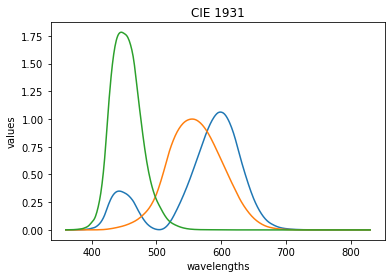

In [462]:
# view cmfs

plt.plot(gt_cmfs["wavelengths"], gt_cmfs["values"])
plt.title("CIE 1931")
plt.xlabel("wavelengths")
plt.ylabel("values")
plt.show()

In [463]:
from utils.XYZ_to_SRGB import XYZ_TO_SRGB

In [464]:
SRGB = XYZ_TO_SRGB()

In [465]:
sRGB_img = SRGB.XYZ_to_sRGB(gt_xyz)

/Users/yuliakokorina/ВШЭ ПМИ/4 курс/Photo/CCV23.HSE-develop/Hackaton/utils/XYZ_to_SRGB.py:27: UserWarning: ffs, use float32 not float64
  warnings.warn("ffs, use float32 not %s" % img.dtype)
/Users/yuliakokorina/ВШЭ ПМИ/4 курс/Photo/CCV23.HSE-develop/Hackaton/utils/XYZ_to_SRGB.py:30: UserWarning: ffs, the range should be in [0, 1] not [-0.017096 1.324982]
  "ffs, the range should be in [0, 1] not [%f %f]" % (img.min(), img.max())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


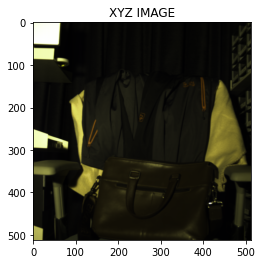

In [466]:
plt.imshow(gt_xyz)
plt.title("XYZ IMAGE")
plt.show()

In [351]:
gt_xyz.shape

(512, 512, 3)

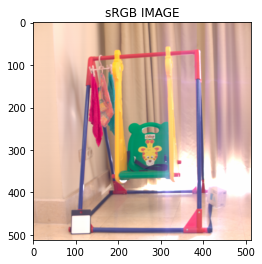

In [352]:
plt.imshow(sRGB_img)
plt.title("sRGB IMAGE")
plt.show()

In [467]:
sample = np.load("./sample/sample.npy", allow_pickle=True)

In [468]:
# sample keys:
# image
# cmfs
# light
# bayer
# mean
# sigma

sample_img   = sample.item().get('image')
sample_cmfs  = sample.item().get('cmfs')
sample_light = sample.item().get('light')
sample_bayer = sample.item().get('bayer')
sample_mean  = sample.item().get('mean')
sample_sigma = sample.item().get('sigma')

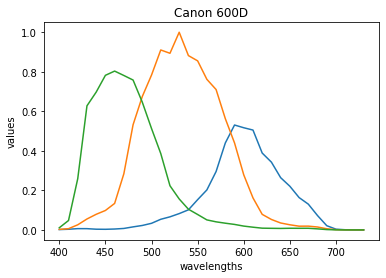

In [469]:
# view cmfs

plt.plot(sample_cmfs["wavelengths"], sample_cmfs["values"])
plt.title("Canon 600D")
plt.xlabel("wavelengths")
plt.ylabel("values")
plt.show()

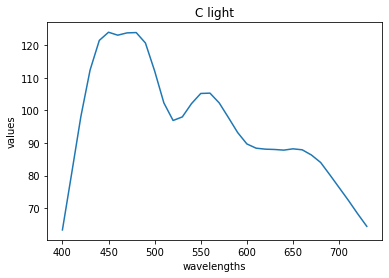

In [470]:
# view light
key = list(sample_light.keys())[0]
plt.plot(sample_cmfs["wavelengths"], np.array(sample_light[key]))
plt.title(f"{key} light")
plt.xlabel("wavelengths")
plt.ylabel("values")
plt.show()

In [471]:
print("Bayer:", sample_bayer, "Noise mean:", sample_mean, "Noise sigma:", sample_sigma)

Bayer: GRBG Noise mean: 0 Noise sigma: [5]


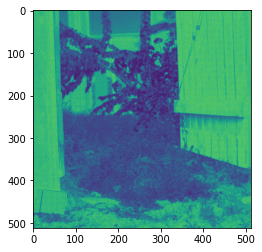

In [472]:
plt.imshow(sample_img)

In [360]:
import torch
import torch.nn as nn

class DebayerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 12, kernel_size=(3, 3), padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.model(x)
        return torch.nn.functional.pixel_shuffle(out, 2)
    
debayer = DebayerModel()
debayer = torch.load('./Debayer.pt', map_location=torch.device('cpu'))

In [361]:
torch.tensor(sample_img.astype(np.float32) / 255)

tensor([[0.9059, 0.4627, 0.9059,  ..., 0.3098, 0.5020, 0.3490],
        [0.4196, 0.8902, 0.4235,  ..., 0.5529, 0.2235, 0.6118],
        [0.9216, 0.5216, 0.9882,  ..., 0.2863, 0.5098, 0.2471],
        ...,
        [0.3216, 0.8588, 0.3608,  ..., 0.7686, 0.3647, 0.7843],
        [0.7176, 0.4275, 0.7961,  ..., 0.3843, 0.7176, 0.4824],
        [0.2824, 0.7725, 0.4275,  ..., 0.6627, 0.3608, 0.7294]])

In [384]:
def read_bayer_image(raw):
    ch_B  = raw[1::2, 1::2]
    ch_Gb = raw[0::2, 1::2]
    ch_R  = raw[0::2, 0::2]
    ch_Gr = raw[1::2, 0::2]
    combined = np.dstack((ch_Gb, ch_R, ch_Gr,ch_B))
    return combined.astype(np.float32) / 255

bayer = read_bayer_image(sample_img)

In [385]:
bayer.shape

(256, 256, 4)

In [386]:
debayered = torch.tensor(bayer).permute(-1, 0, 1)
debayered_img = debayer(debayered)
debayered.shape, debayered_img.shape

(torch.Size([4, 256, 256]), torch.Size([3, 512, 512]))

In [387]:
debayered_img = debayered_img[:,:,:]

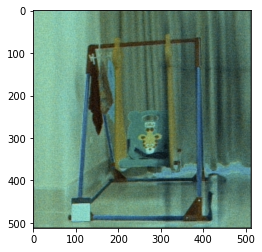

In [388]:
plt.imshow(debayered_img.permute(1,2, 0).detach().numpy())

In [389]:
class DnCNN(nn.Module):
    def __init__(self, d=5):
        super().__init__()
        self.d = d
        self.enter = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU()
        )
        self.core = []
        for i in range(d):
            self.core.append(nn.Conv2d(64, 64, 3, padding=1))
            self.core.append(nn.BatchNorm2d(64))
            self.core.append(nn.ReLU())
        self.out = nn.Conv2d(64, 3, 3, padding=1)
        self.model = nn.Sequential(self.enter, *self.core, self.out)
  
    def forward(self, x):
        return self.model(x)
    
denoise = DnCNN(20)
denoise.load_state_dict(torch.load('DnCNN.pt', map_location=torch.device('cpu')))
denoise.eval()

DnCNN(
  (enter): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (out): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momen

In [390]:
with torch.inference_mode():
    den_img = denoise(debayered_img.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


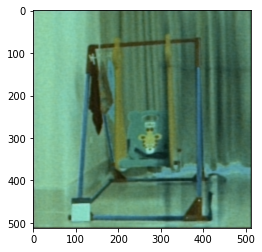

In [391]:
den_img = den_img.squeeze(0)
plt.imshow((debayered_img - den_img).permute(1,2, 0).detach().numpy())

In [392]:
dbdn_img = (debayered_img - den_img)

In [393]:
dbdn_img.min(), dbdn_img.max()

(tensor(-0.0225, grad_fn=<MinBackward1>),
 tensor(0.8947, grad_fn=<MaxBackward1>))

In [394]:
dbdn_img.shape

torch.Size([3, 512, 512])

In [423]:
import pickle

lin_model = pickle.load(open('lin_reg1.sav', 'rb'))
poly = pickle.load(open('poly1.sav', 'rb'))
img_to_transform = poly.transform(dbdn_img[:,:,:].detach().permute(1,2,0).numpy().reshape(-1, 3))
img_transformed = lin_model.predict(img_to_transform).reshape(512, 512, 3)

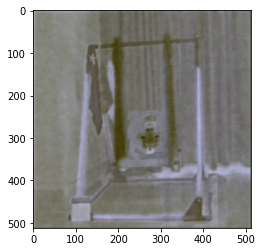

In [446]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=False)
in_ = dbdn_img[:,:,:].detach().permute(1,2,0).numpy().reshape(-1, 3)
lin_reg.fit(in_, gt_xyz.reshape(-1, 3))

tr = lin_reg.predict(in_).reshape(512, 512, 3)
#img_transformed = np.clip(tr[:,:,:], 0, 1)
plt.imshow((tr - tr.min()) / (tr.max() - tr.min()))

/Users/yuliakokorina/ВШЭ ПМИ/4 курс/Photo/CCV23.HSE-develop/Hackaton/utils/XYZ_to_SRGB.py:27: UserWarning: ffs, use float32 not float64
  warnings.warn("ffs, use float32 not %s" % img.dtype)
/Users/yuliakokorina/ВШЭ ПМИ/4 курс/Photo/CCV23.HSE-develop/Hackaton/utils/XYZ_to_SRGB.py:30: UserWarning: ffs, the range should be in [0, 1] not [-0.063460 1.336990]
  "ffs, the range should be in [0, 1] not [%f %f]" % (img.min(), img.max())


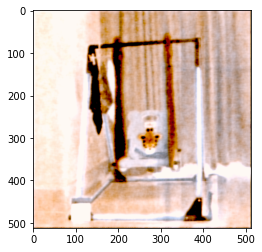

In [434]:
cst_img = np.clip(SRGB.XYZ_to_sRGB(img_transformed),0,1)
plt.imshow(cst_img)

In [399]:
balanced_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3, 3), padding='same'),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same'),
    nn.Flatten(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 3)
)

balanced_model.load_state_dict(torch.load('./BalanceCNN.pt', map_location=torch.device('cpu')))

/Users/yuliakokorina/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [400]:
import cv2
from PIL import Image

balanced_model.eval()
with torch.inference_mode():
    in_ = np.uint8(cst_img * 255)
    in_ = Image.fromarray(in_)
    balance_in = torch.tensor(np.array(in_.resize((96, 96), Image.BILINEAR)), dtype=torch.float32) / 255 
    print(balance_in.max(), balance_in.min(), balance_in.shape)
    balanced_out = balanced_model(balance_in.permute(-1,0,1).unsqueeze(0))

tensor(0.9961) tensor(0.0824) torch.Size([96, 96, 3])


In [447]:
balanced_out = balanced_out / torch.norm(balanced_out)
balanced_out

tensor([[-0.0382, -0.5927, -0.8045]])

In [449]:
(cst_img / balanced_out.squeeze()).min()

tensor(-26.1812, dtype=torch.float64)

In [455]:
r = cst_img / -balanced_out.squeeze()
balanced_img = torch.clip(r / r.max(), 0, 1)

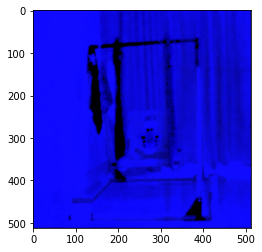

In [457]:
plt.imshow(balanced_img[[1,2,0]])